## Requirements

In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

## Dataset Preparation

In [26]:
df_test = pd.read_csv("data/data_test.csv", encoding='utf-8')
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2160 entries, 0 to 2159
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 2160 non-null   int64  
 1   tanggal_waktu      2160 non-null   object 
 2   suhu               2160 non-null   float64
 3   beban_listrik      2160 non-null   float64
 4   kecepatan_angin    2160 non-null   float64
 5   tekanan_udara      2160 non-null   float64
 6   dampak_lingkungan  2160 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 118.3+ KB


In [27]:
df_train = pd.read_csv("data/data_train.csv", encoding='utf-8')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24336 entries, 0 to 24335
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 24336 non-null  int64  
 1   tanggal_waktu      24336 non-null  object 
 2   suhu               24336 non-null  float64
 3   beban_listrik      24336 non-null  float64
 4   kecepatan_angin    24336 non-null  float64
 5   tekanan_udara      24336 non-null  float64
 6   dampak_lingkungan  24336 non-null  object 
 7   konsumsi_listrik   24283 non-null  float64
dtypes: float64(5), int64(1), object(2)
memory usage: 1.5+ MB


## Preprocessing

In [28]:
# Ubah tipe data menjadi datetime
df_train["tanggal_waktu"] = pd.to_datetime(df_train["tanggal_waktu"])
df_test["tanggal_waktu"] = pd.to_datetime(df_test["tanggal_waktu"])

df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24336 entries, 0 to 24335
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   ID                 24336 non-null  int64         
 1   tanggal_waktu      24336 non-null  datetime64[ns]
 2   suhu               24336 non-null  float64       
 3   beban_listrik      24336 non-null  float64       
 4   kecepatan_angin    24336 non-null  float64       
 5   tekanan_udara      24336 non-null  float64       
 6   dampak_lingkungan  24336 non-null  object        
 7   konsumsi_listrik   24283 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 1.5+ MB


In [29]:
# Cek missing values
print(df_train.isnull().sum())

ID                    0
tanggal_waktu         0
suhu                  0
beban_listrik         0
kecepatan_angin       0
tekanan_udara         0
dampak_lingkungan     0
konsumsi_listrik     53
dtype: int64


In [30]:
# Cek missing values
print(df_test.isnull().sum())

ID                   0
tanggal_waktu        0
suhu                 0
beban_listrik        0
kecepatan_angin      0
tekanan_udara        0
dampak_lingkungan    0
dtype: int64


In [31]:
# Isi missing values jika ada
df_train["tekanan_udara"] = df_train["tekanan_udara"].fillna(df_train["tekanan_udara"].interpolate())
df_train["konsumsi_listrik"] = df_train["konsumsi_listrik"].fillna(method="ffill")

print(df_train.isnull().sum())

ID                   0
tanggal_waktu        0
suhu                 0
beban_listrik        0
kecepatan_angin      0
tekanan_udara        0
dampak_lingkungan    0
konsumsi_listrik     0
dtype: int64


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_27084\1436221346.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_train["konsumsi_listrik"] = df_train["konsumsi_listrik"].fillna(method="ffill")


In [32]:
# Encode dampak_lingkungan
df_train = pd.get_dummies(df_train, columns=["dampak_lingkungan"])
df_test = pd.get_dummies(df_test, columns=["dampak_lingkungan"])

df_train.head()

,ID,tanggal_waktu,suhu,beban_listrik,kecepatan_angin,tekanan_udara,konsumsi_listrik,dampak_lingkungan_A,dampak_lingkungan_B,dampak_lingkungan_C
0,0,2021-09-17 00:00:00,15.9,-17.1,571.910,1003.0,216.0,True,False,False
1,1,2021-09-17 01:00:00,15.5,-19.3,575.040,996.0,210.0,True,False,False
2,2,2021-09-17 02:00:00,15.1,-20.0,578.435,1000.0,225.0,True,False,False
3,3,2021-09-17 03:00:00,15.9,-17.1,582.580,995.0,216.0,True,False,False
4,4,2021-09-17 04:00:00,15.9,-19.3,586.600,1005.0,222.0,True,False,False


In [33]:
df_test.head()

,ID,tanggal_waktu,suhu,beban_listrik,kecepatan_angin,tekanan_udara,dampak_lingkungan_A,dampak_lingkungan_B,dampak_lingkungan_C
0,32184,2025-05-20 00:00:00,27.8,7.1,2.075,980.0,True,False,False
1,32185,2025-05-20 01:00:00,26.2,7.1,5.005,988.0,True,False,False
2,32186,2025-05-20 02:00:00,27.4,6.4,7.385,990.0,True,False,False
3,32187,2025-05-20 03:00:00,26.6,9.3,1.890,973.0,True,False,False
4,32188,2025-05-20 04:00:00,26.2,9.3,2.540,989.0,True,False,False


In [34]:
# Sort sesuai dengan tanggal_waktu
df_cleaned = df_train.sort_values("tanggal_waktu")
df_test = df_test.sort_values("tanggal_waktu")
df_cleaned.head()

,ID,tanggal_waktu,suhu,beban_listrik,kecepatan_angin,tekanan_udara,konsumsi_listrik,dampak_lingkungan_A,dampak_lingkungan_B,dampak_lingkungan_C
0,0,2021-09-17 00:00:00,15.9,-17.1,571.910,1003.0,216.0,True,False,False
1,1,2021-09-17 01:00:00,15.5,-19.3,575.040,996.0,210.0,True,False,False
2,2,2021-09-17 02:00:00,15.1,-20.0,578.435,1000.0,225.0,True,False,False
3,3,2021-09-17 03:00:00,15.9,-17.1,582.580,995.0,216.0,True,False,False
4,4,2021-09-17 04:00:00,15.9,-19.3,586.600,1005.0,222.0,True,False,False


In [35]:
# Cek outlier
df_cleaned.describe()

,ID,tanggal_waktu,suhu,beban_listrik,kecepatan_angin,tekanan_udara,konsumsi_listrik
count,24336.000000,24336,24336.000000,24336.000000,24336.000000,24336.000000,24336.000000
mean,16027.381657,2023-07-16 19:22:53.964496896,25.161082,-1.783510,23.631823,986.012964,531.997411
min,0.000000,2021-09-17 00:00:00,12.700000,-32.900000,1.075000,953.000000,174.000000
25%,8051.750000,2022-08-18 11:45:00,21.100000,-10.700000,3.165000,977.000000,219.000000
50%,16079.500000,2023-07-18 23:30:00,25.800000,-1.400000,6.670000,986.000000,270.000000
75%,24155.250000,2024-06-19 11:15:00,29.400000,7.900000,22.700000,995.000000,342.000000
max,32183.000000,2025-05-19 23:00:00,35.300000,18.600000,586.600000,1024.000000,99999.000000
std,9299.957517,NaN,4.888658,10.521302,46.781818,12.130831,4820.776434


In [36]:
df_test.describe()

,ID,tanggal_waktu,suhu,beban_listrik,kecepatan_angin,tekanan_udara
count,2160.000000,2160,2160.000000,2160.000000,2160.000000,2160.000000
mean,33545.633333,2025-07-15 17:37:59.999999744,23.883611,-3.411574,27.656924,991.381481
min,32184.000000,2025-05-20 00:00:00,15.500000,-22.100000,1.075000,965.000000
25%,32915.750000,2025-06-19 11:45:00,20.600000,-11.400000,2.790000,985.000000
50%,33623.500000,2025-07-18 23:30:00,24.200000,-3.600000,5.195000,992.000000
75%,34355.250000,2025-08-18 11:15:00,27.000000,5.000000,17.026250,998.000000
max,34895.000000,2025-09-09 23:00:00,34.100000,13.600000,442.930000,1016.000000
std,820.783400,NaN,3.874791,9.139108,62.632300,9.098241


In [37]:
df_train_interpolated = df_cleaned.copy()

# 1. Hitung batas atas
Q1 = df_train_interpolated['konsumsi_listrik'].quantile(0.25)
Q3 = df_train_interpolated['konsumsi_listrik'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR

# 2. Ganti outlier dengan NaN
df_train_interpolated.loc[df_train_interpolated['konsumsi_listrik'] > upper_bound, 'konsumsi_listrik'] = np.nan

# 3. Lakukan interpolasi berbasis waktu
df_train_interpolated.set_index('tanggal_waktu', inplace=True)
df_train_interpolated['konsumsi_listrik'].interpolate(method='time', inplace=True)
df_train_interpolated.reset_index(inplace=True) # Kembalikan index seperti semula

print("Proses Interpolasi selesai. Gunakan 'df_train_interpolated' untuk training.")

df_train_interpolated.info()

Proses Interpolasi selesai. Gunakan 'df_train_interpolated' untuk training.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24336 entries, 0 to 24335
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   tanggal_waktu        24336 non-null  datetime64[ns]
 1   ID                   24336 non-null  int64         
 2   suhu                 24336 non-null  float64       
 3   beban_listrik        24336 non-null  float64       
 4   kecepatan_angin      24336 non-null  float64       
 5   tekanan_udara        24336 non-null  float64       
 6   konsumsi_listrik     24336 non-null  float64       
 7   dampak_lingkungan_A  24336 non-null  bool          
 8   dampak_lingkungan_B  24336 non-null  bool          
 9   dampak_lingkungan_C  24336 non-null  bool          
dtypes: bool(3), datetime64[ns](1), float64(5), int64(1)
memory usage: 1.4 MB


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_27084\3510887517.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train_interpolated['konsumsi_listrik'].interpolate(method='time', inplace=True)


In [38]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2160 entries, 0 to 2159
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID                   2160 non-null   int64         
 1   tanggal_waktu        2160 non-null   datetime64[ns]
 2   suhu                 2160 non-null   float64       
 3   beban_listrik        2160 non-null   float64       
 4   kecepatan_angin      2160 non-null   float64       
 5   tekanan_udara        2160 non-null   float64       
 6   dampak_lingkungan_A  2160 non-null   bool          
 7   dampak_lingkungan_B  2160 non-null   bool          
 8   dampak_lingkungan_C  2160 non-null   bool          
dtypes: bool(3), datetime64[ns](1), float64(4), int64(1)
memory usage: 107.7 KB


In [39]:
df_train_interpolated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24336 entries, 0 to 24335
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   tanggal_waktu        24336 non-null  datetime64[ns]
 1   ID                   24336 non-null  int64         
 2   suhu                 24336 non-null  float64       
 3   beban_listrik        24336 non-null  float64       
 4   kecepatan_angin      24336 non-null  float64       
 5   tekanan_udara        24336 non-null  float64       
 6   konsumsi_listrik     24336 non-null  float64       
 7   dampak_lingkungan_A  24336 non-null  bool          
 8   dampak_lingkungan_B  24336 non-null  bool          
 9   dampak_lingkungan_C  24336 non-null  bool          
dtypes: bool(3), datetime64[ns](1), float64(5), int64(1)
memory usage: 1.4 MB


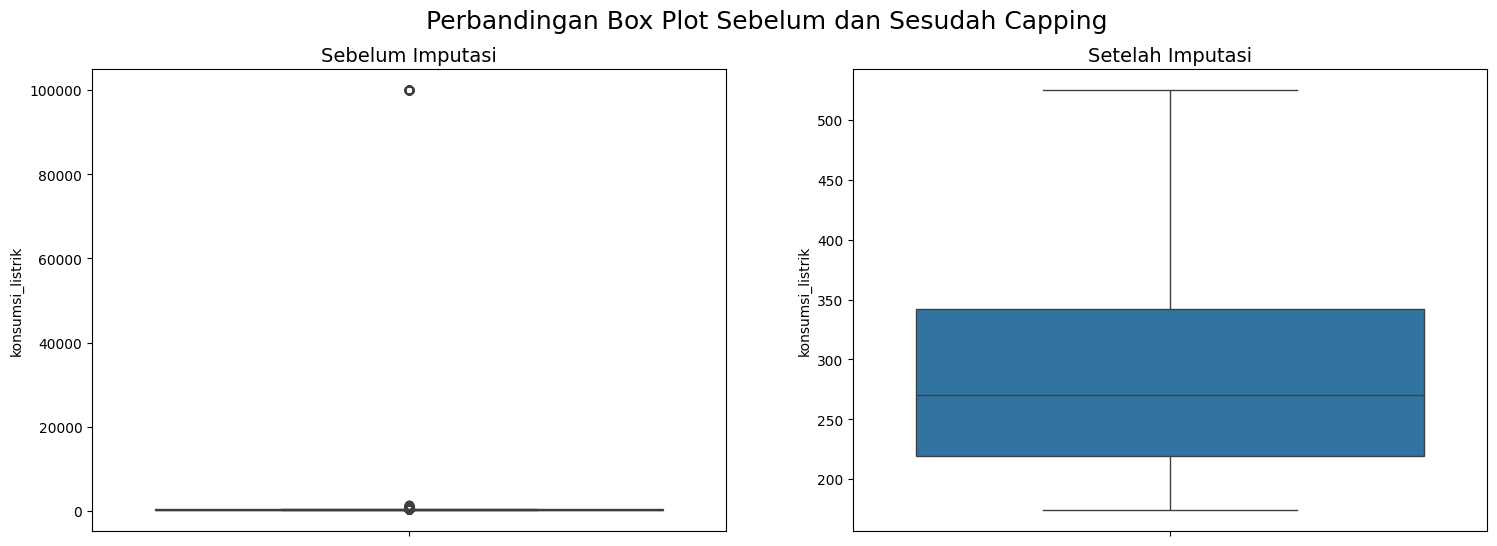

In [40]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
sns.boxplot(y=df_train['konsumsi_listrik'])
plt.title('Sebelum Imputasi', fontsize=14)

plt.subplot(1, 2, 2)
sns.boxplot(y=df_train_interpolated['konsumsi_listrik'])
plt.title('Setelah Imputasi', fontsize=14)

plt.suptitle('Perbandingan Box Plot Sebelum dan Sesudah Capping', fontsize=18)
plt.show()

## EDA

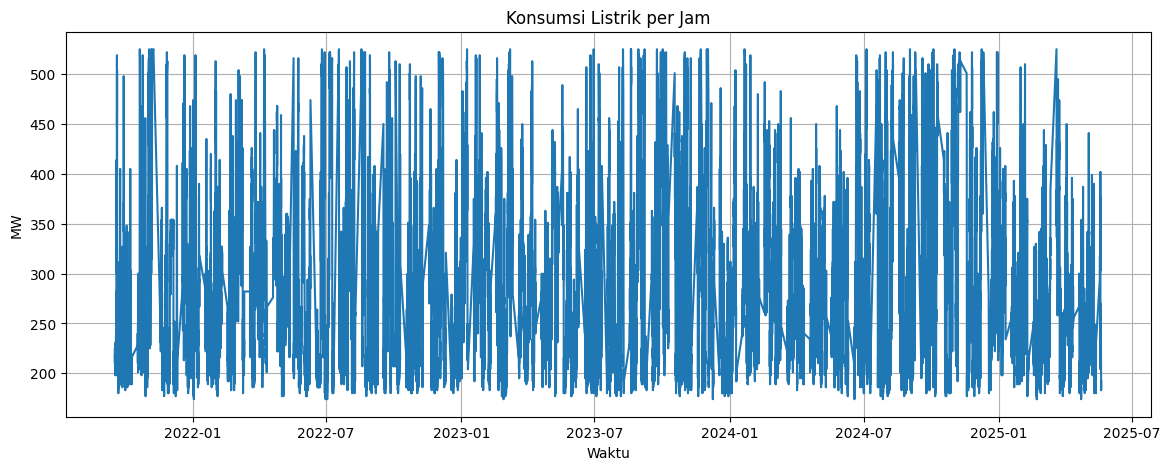

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualisasi konsumsi listrik
plt.figure(figsize=(14,5))
plt.plot(df_train_interpolated["tanggal_waktu"], df_train_interpolated["konsumsi_listrik"])
plt.title("Konsumsi Listrik per Jam")
plt.xlabel("Waktu")
plt.ylabel("MW")
plt.grid(True)
plt.show()

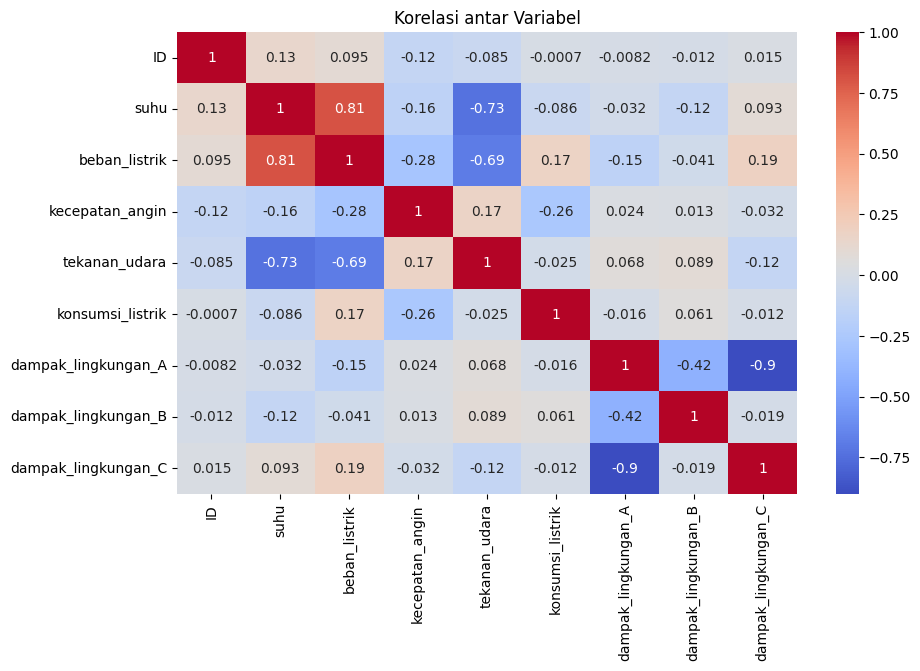

In [42]:
# Korelasi antar fitur
plt.figure(figsize=(10,6))
sns.heatmap(df_train_interpolated.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Korelasi antar Variabel")
plt.show()

## Modelling

### LSTM

In [43]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [44]:
# Fitur yang digunakan
features = ["suhu", "beban_listrik", "kecepatan_angin", "tekanan_udara",
            "dampak_lingkungan_A", "dampak_lingkungan_B", "dampak_lingkungan_C"]

# Normalisasi
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df_train_interpolated[features])
scaled_target = scaler.fit_transform(df_train_interpolated[["konsumsi_listrik"]])

In [45]:
# Buat sequence untuk LSTM
def create_sequences(features, target, time_steps=24):
    X, y = [], []
    for i in range(time_steps, len(features)):
        X.append(features[i-time_steps:i])
        y.append(target[i])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_features, scaled_target)

In [46]:
# Train-test split
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X, y, shuffle=False, test_size=0.2)

In [47]:
# Define the improved LSTM model
model_lstm = Sequential([
    Bidirectional(LSTM(units=100, return_sequences=True), input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.3),
    Bidirectional(LSTM(units=50)),
    Dropout(0.3),
    Dense(units=25, activation='relu'),
    Dense(units=1)
])

model_lstm.compile(optimizer='adam', loss='mse')


C:\Users\LENOVO\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [48]:
# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_lstm.compile(optimizer=optimizer, loss='mean_squared_error')

model_lstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 24, 200)        │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 200)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 100)            │       100,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         2,525 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 189,351 (739.65 KB)

 Trainable params: 189,351 (739.65 KB)

 Non-trainable params: 0 (0.00 B)

In [49]:
from tensorflow.keras.callbacks import EarlyStopping

# Set up Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train model
history = model_lstm.fit(X_train_lstm, y_train_lstm, epochs=25, batch_size=32, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/25
547/547 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.0561 - val_loss: 0.0435
Epoch 2/25
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0411 - val_loss: 0.0346
Epoch 3/25
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0381 - val_loss: 0.0337
Epoch 4/25
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0364 - val_loss: 0.0343
Epoch 5/25
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0364 - val_loss: 0.0341
Epoch 6/25
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0347 - val_loss: 0.0381
Epoch 7/25
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0339 - val_loss: 0.0318
Epoch 8/25
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0335 - val_loss: 0.0311
Epoch 9/25
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0326 - val_loss: 0.0283
Epoch 10/25
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0322 - val_loss: 0.0294
Epoch 11/25
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0311 - val_loss: 0.0333
Epoch 12/25
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 

In [50]:
# Prediksi
y_pred_lstm = model_lstm.predict(X_test_lstm)

# Inverse transform
y_pred_inv_lstm = scaler.inverse_transform(np.hstack((np.zeros((y_pred_lstm.shape[0], len(features))), y_pred_lstm)))[:, -1]
y_test_inv_lstm = scaler.inverse_transform(np.hstack((np.zeros((y_test_lstm.shape[0], len(features))), y_test_lstm)))[:, -1]

152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


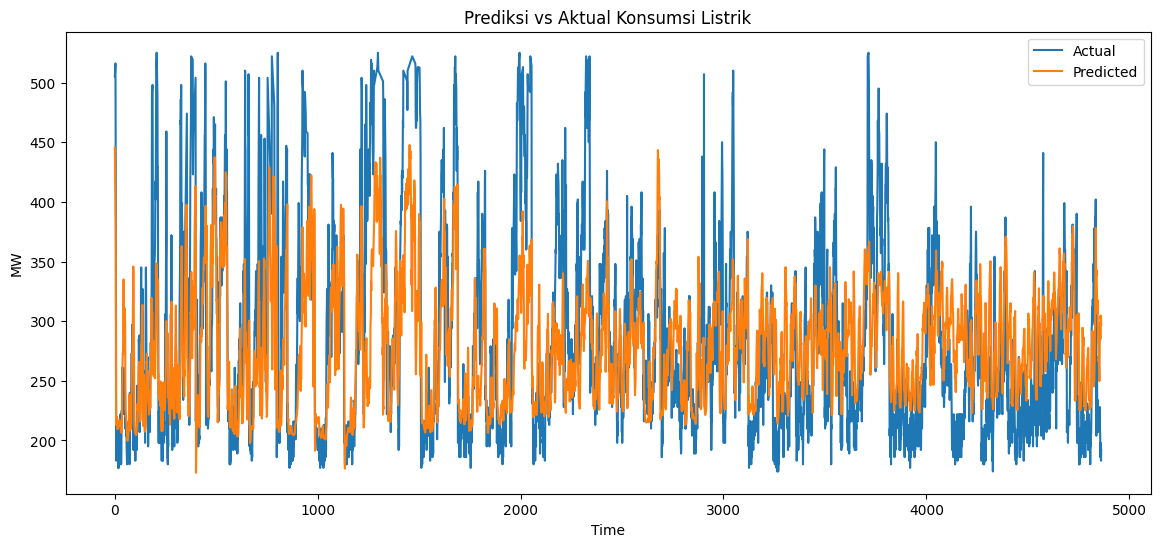

In [51]:
# Visualisasi hasil
plt.figure(figsize=(14,6))
plt.plot(y_test_inv_lstm, label="Actual")
plt.plot(y_pred_inv_lstm, label="Predicted")
plt.title("Prediksi vs Aktual Konsumsi Listrik")
plt.xlabel("Time")
plt.ylabel("MW")
plt.legend() 
plt.show()

## Evaluasi

In [52]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

In [53]:
def evaluate_model(df_test, forecast):
    mse = mean_squared_error(df_test, forecast)
    rmse = np.sqrt(mse)
    r2 = r2_score(df_test, forecast)
    mape = mean_absolute_percentage_error(df_test, forecast)

    # print(f'p = {p}, d = {d}, q = {q}')
    print(f'MSE = {mse:.4f}')
    print(f'RMSE = {rmse:.4f}')
    print(f'R² = {r2:.4f}')
    print(f'MAPE = {mape:.4f}')

### LSTM

In [54]:
evaluate_model(y_test_inv_lstm, y_pred_inv_lstm)

MSE = 4573.9100
RMSE = 67.6307
R² = 0.4027
MAPE = 0.1636


## Prediction

In [55]:
import pandas as pd
import numpy as np

test_ids = df_test['ID'].values

def export_prediction(prediction_values, test_ids, filename="submission.csv"):
    """
    Fungsi untuk mengekspor hasil prediksi ke dalam file CSV.
    Versi ini dirancang untuk robust dan bisa menangani output dari 
    Scikit-learn, XGBoost, maupun TensorFlow/Keras.
    """
    print(f"📦 Memulai proses ekspor ke file '{filename}'...")

    try:
        # Langkah krusial: Pastikan array prediksi adalah 1-dimensi
        # Model Keras/TensorFlow sering menghasilkan output 2D (shape: [n, 1])
        if prediction_values.ndim > 1:
            print("   - Info: Meratakan (flatten) array prediksi dari 2D menjadi 1D.")
            prediction_values = prediction_values.flatten()

        # Membuat DataFrame dari ID dan hasil prediksi
        submission_df = pd.DataFrame({
            'ID': test_ids,
            'konsumsi_listrik': prediction_values
        })
        print("   - DataFrame submission berhasil dibuat.")

        # Memastikan tidak ada nilai prediksi negatif
        submission_df['konsumsi_listrik'] = submission_df['konsumsi_listrik'].clip(lower=0)
        
        # Menyimpan DataFrame ke file CSV
        submission_df.to_csv(filename, index=False)

        print(f"\n🎉 Berhasil! File '{filename}' telah disimpan.")
        print("\nBerikut adalah 5 baris pertama dari file Anda:")
        
        from IPython.display import display
        display(submission_df.head())

    except Exception as e:
        print(f"❌ Terjadi error saat mengekspor file: {e}")

### LSTM

In [56]:
# --- 1. DEFINE SCALERS and FIT ON TRAINING DATA ---
# It's better practice to use separate scalers for features and the target.
from sklearn.preprocessing import MinMaxScaler

features = ["suhu", "beban_listrik", "kecepatan_angin", "tekanan_udara",
            "dampak_lingkungan_A", "dampak_lingkungan_B", "dampak_lingkungan_C"]
target = "konsumsi_listrik"

feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Fit scalers only on the training data
feature_scaler.fit(df_train_interpolated[features])
target_scaler.fit(df_train_interpolated[[target]])


# --- 2. PREPARE THE TEST DATA FOR PREDICTION ---
# The model needs the last 24 hours of training data to predict the first test sample.
time_steps = 24

# Get the last `time_steps` from training features and combine with test features
last_train_features = df_train_interpolated[features].tail(time_steps)
test_features = df_test[features]
combined_features_for_scaling = pd.concat([last_train_features, test_features], ignore_index=True)

# Scale the combined features using the *already fitted* feature_scaler
scaled_combined_features = feature_scaler.transform(combined_features_for_scaling)

# Create sequences for the test set
X_to_predict = []
# We need to create one sequence for each row in the original df_test
for i in range(len(df_test)):
    # The sequence for the i-th test point starts at index i in the combined/scaled data
    start_index = i
    end_index = i + time_steps
    X_to_predict.append(scaled_combined_features[start_index:end_index])

X_to_predict = np.array(X_to_predict)

print(f"✅ Test data prepared successfully.")
print(f"   Input shape for prediction: {X_to_predict.shape}")


# --- 3. PREDICT AND EXPORT ---
# Predict on the fully preprocessed test data
scaled_predictions = model_lstm.predict(X_to_predict)

# Inverse transform the predictions to get the actual MW values
final_predictions = target_scaler.inverse_transform(scaled_predictions)

# Call your export function to create the submission file
export_prediction(final_predictions, test_ids, filename="submission_lstm.csv")

✅ Test data prepared successfully.
   Input shape for prediction: (2160, 24, 7)
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
📦 Memulai proses ekspor ke file 'submission_lstm.csv'...
   - Info: Meratakan (flatten) array prediksi dari 2D menjadi 1D.
   - DataFrame submission berhasil dibuat.

🎉 Berhasil! File 'submission_lstm.csv' telah disimpan.

Berikut adalah 5 baris pertama dari file Anda:


,ID,konsumsi_listrik
0,32184,286.721710
1,32185,258.218109
2,32186,258.587982
3,32187,241.758850
4,32188,274.866821


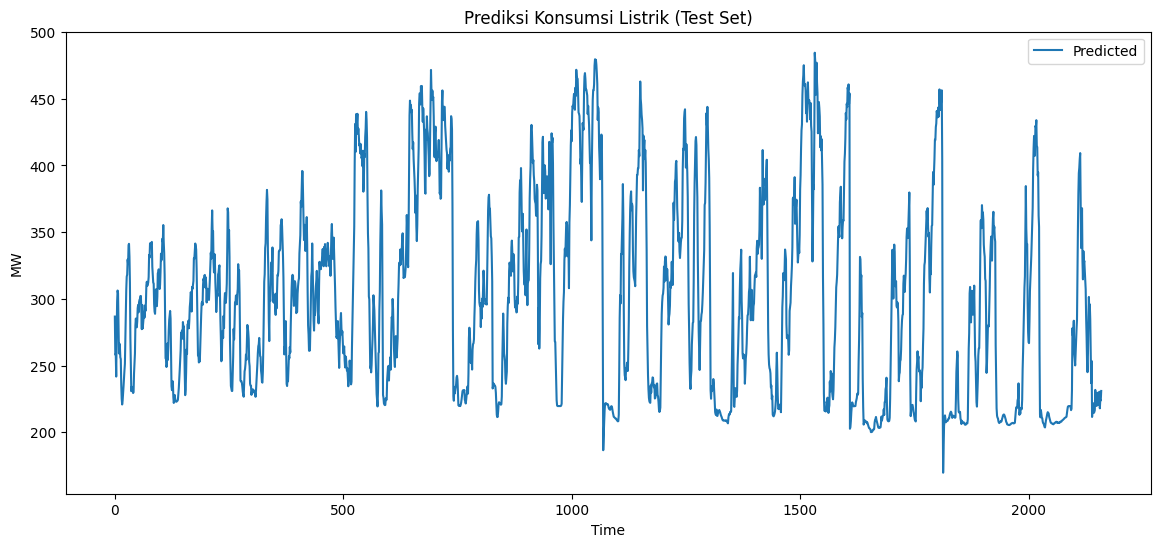

In [57]:
# Visualisasi hasil
plt.figure(figsize=(14,6))
plt.plot(final_predictions, label="Predicted")
plt.title("Prediksi Konsumsi Listrik (Test Set)")
plt.xlabel("Time")
plt.ylabel("MW")
plt.legend()
plt.show()